In [33]:
import gymnasium as gym
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
import torch.nn as nn
from itertools import count
import imageio


import torch as T
from torch import optim
import torch.nn.functional as F
from collections import deque , namedtuple
from itertools import count
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

https://www.gymlibrary.dev/environments/box2d/lunar_lander/

## Planning:
The goal is to use DQN to solve the lunar lander problem.

Currently I am unclear on the following:
Exactly how to set up the network to receive inputs and outputs from the system
What kind of loss function should be used in this setup to make sure that it is learning correctly.
How to account for the various kinds of things can be observed in the observation space.

## approach
A good first step would be to try and experiment with basic approaches messing around with the system to get a grasp of it.
Then I'd like to experiment with a basic neural network feeding in maybe 2 of the parameters.

Edit: I think I will try to use the 4 parameters as inputs to the network and see how that goes.
Playing with the network structure and the loss function should be the next step.
Messing around trying to solve it by hand will probably not be very useful.



TODO:
- [*] Create agent class that can interact with the environment
- [*] Add the neural network class
- [*] Add the action selection from the neural network to the actions of the agent
- [*] Add the loss function to the agent
- [*] Add the replay buffer to the agent
- [*] Add the epsilon greedy policy to the agent
- [*] Add the training loop to the agent

In [13]:
class network(nn.Module):
    def __init__(self, n_observations, n_actions, fc1_dims=256, fc2_dims=256):
        super(network, self).__init__()
        self.layer1 = nn.Linear(n_observations, fc1_dims)
        self.layer2 = nn.Linear(fc1_dims, fc2_dims)
        self.layer3 = nn.Linear(fc2_dims, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    


In [14]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class replay_memory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [35]:
class Agent():
    def __init__(self, env) -> None:
        n_actions = env.action_space.n
        state, info = env.reset()
        n_observations = len(state)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.policy_network =  network(n_observations = n_observations, n_actions=n_actions).to(self.device)
        self.target_network = network(n_observations = n_observations, n_actions=n_actions).to(self.device)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.memory = replay_memory(100000)
        self.steps_done = 0
        self.batch_size = 128
        self.episode_durations = []
        self.loss_record = []
        self.episode_rewards = []

        self.gamma = 0.99
        self.eps_start = 0.9
        self.eps_end = 0.05
        self.eps_decay = 1000
        self.tau = 0.005
        self.LR = 0.001

        self.max_score = -math.inf
        self.min_score = math.inf
        self.avg_score = 0

        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.LR, amsgrad=True)
        
        self.chkpt_file = 'tmp/lunar_lander'


    
    def save_checkpoint(self):
        T.save(self.network.state_dict(), self.chkpt_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.chkpt_file))
        
    
    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            with T.no_grad():
                return self.policy_network(state).to(self.device).max(1)[1].view(1, 1)
        else:
            return T.tensor([[env.action_space.sample()]], device=self.device, dtype=T.long)

    def plot_durations(self, show_result=False):
        plt.figure(2)
        plt.clf()
        durations_t = T.tensor(self.episode_durations, dtype=T.float)
        plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())

        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = T.cat((T.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                # display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

    def plot_rewards(self, show_result=False):
        plt.figure(2)
        plt.clf()
        rewards_t = T.tensor(self.episode_rewards, dtype=T.float)
        plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.plot(rewards_t.numpy())

        # Take 100 episode averages and plot them too
        if len(rewards_t) >= 100:
            means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
            means = T.cat((T.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                # display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

    def plot_loss(self, show_result=False):
        plt.figure(2)
        plt.clf()
        loss_t = T.tensor(self.loss_record, dtype=T.float)
        plt.title('Training...')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.plot(loss_t.numpy())
        plt.pause(0.001)
        if is_ipython:
            display.display(plt.gcf())
            # display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

        
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        # converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = T.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=T.bool)
        non_final_next_states = T.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = T.cat(batch.state)
        action_batch = T.cat(batch.action)
        reward_batch = T.cat(batch.reward)



        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_network
        state_action_values = self.policy_network(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_network; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = T.zeros(self.batch_size, device=device)
        with T.no_grad():
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        self.loss_record.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        T.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)
        self.optimizer.step()

    
    def train(self, num_episodes, env):
        
        pbar = tqdm(range(1,num_episodes))
        for i_episode in pbar:
            # Initialize the environment and get it's state
            state, info = env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            accumulated_reward = 0
            for t in count():
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = env.step(action.item())
                accumulated_reward += reward
                reward = torch.tensor([reward], device=device)
                done = terminated or truncated

                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

                # Store the transition in memory
                self.memory.push(state, action, next_state, reward)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                self.optimize_model()

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = self.target_network.state_dict()
                policy_net_state_dict = self.policy_network.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
                self.target_network.load_state_dict(target_net_state_dict)

                if done:
                    self.episode_rewards.append(accumulated_reward)
                    self.episode_durations.append(t + 1)
                    break

        print('Complete')
        self.plot_durations()
        plt.ioff()
        plt.show()
        self.plot_loss()
        plt.ioff()
        plt.show()
        self.plot_rewards()
        plt.ioff()
        plt.show()
    
    # Run episode
    def run_episode(self, env, num_episodes=1):
        total_reward = []
        for episode in range(num_episodes):
            episode_reward = 0
            state, info = env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            terminated = False
            while not terminated: 
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = env.step(action.item())
                episode_reward += reward
            total_reward.append(episode_reward)

        return np.mean(total_reward)


    def run_episode_and_save_gif(self, env, num_episodes=1, gif_path='episode.gif'):
        frames = []  # store frames here

        for episode in range(num_episodes):
            episode_reward = 0
            state, info = env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            terminated = False
            while not terminated: 
                # Render environment and save to frames
                frame = env.render()
                frames.append(frame)
                
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = env.step(action.item())

        # Save frames to gif
        imageio.mimsave(gif_path, frames, 'GIF', duration=20)




observation space: Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)
action space: Discrete(4)


100%|██████████| 19/19 [00:43<00:00,  2.27s/it]

Complete


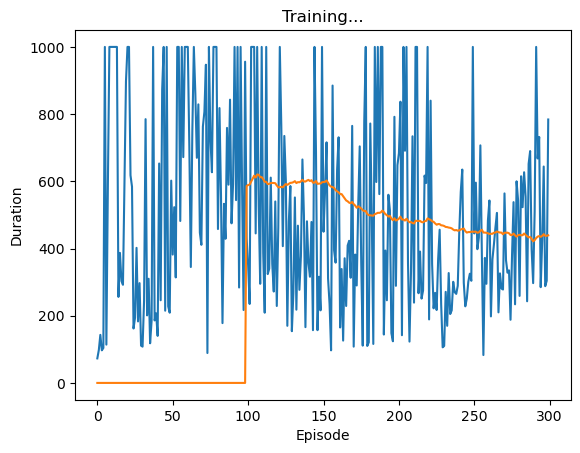

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

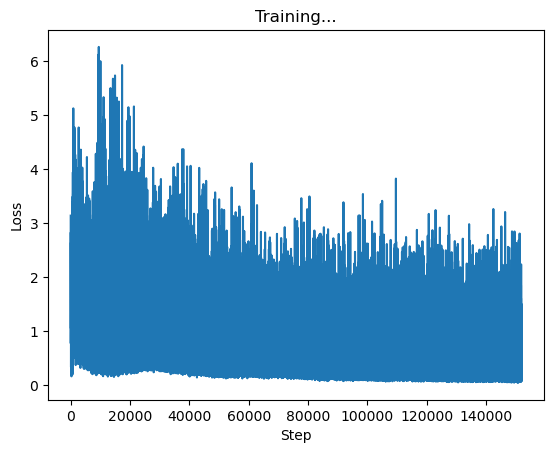

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

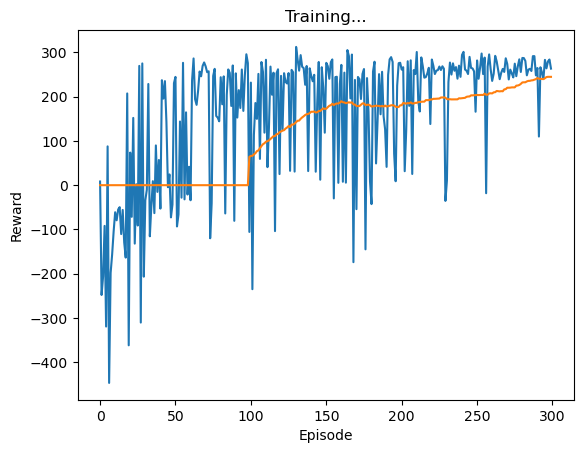

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [48]:
# print gym environment information
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5
    # render_mode="rgb_array"
)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

# agent = Agent(env)

# agent.run_episode_and_save_gif(env)
agent.train(20,env)